In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import constants as const
from scipy.special import erfc
import pandas as pd

In [2]:
average_power_sweep = np.logspace(-2, -0.3, 1001) *1e-3
print(average_power_sweep)
optical_links = {}

[1.00000000e-05 1.00392207e-05 1.00785951e-05 ... 4.97278863e-04
 4.99229224e-04 5.01187234e-04]


In [3]:
tud_ssc_2018_data = pd.read_csv('tud_ssc_2018_53gbps_nrz.csv')
imec_jlt_2019_data = pd.read_csv('imec_jlt_2019_56gbps_nrz.csv')
amd_ssc_2020_data = pd.read_csv('amd_ssc_2020_50gbps_nrz.csv')
amd_isscc_2023_data = pd.read_csv('amd_isscc_2023_56gbps_nrz.csv')
uoft_ssc_2023_data = pd.read_csv('uoft_ssc_2023_56gbps_nrz.csv')

In [4]:
class OpticalLink:
  def __init__(
      self,
      responsivity = 0.9,
      bandwidth = 56e9,
      average_power = 56e-6,
      extinction_ratio = 3.7,
      temperature = 300,
      tia_irn = 3e-6,
      relative_intensity_noise = -140,  
      eye_close_penalty = 0.8,
  ):
    self._responsivity = responsivity
    self._bandwidth = bandwidth
    self._average_power = average_power
    self._extinction_ratio = 10**(-extinction_ratio/10)
    self._temperature = temperature
    self._relative_intensity_noise = 10**(relative_intensity_noise / 10)
    self._tia_irn = tia_irn
    self._eye_close_penalty = eye_close_penalty
    self.ber()
  
  def update(self, **kwargs):
    for key, value in kwargs.items():
      setattr(self, key, value)
    self.ber()

  def power(self):
    self._power_1 = self._average_power * 2 / (1 + self._extinction_ratio)
    self._power_0 = self._power_1 * self._extinction_ratio
  
  def shot_noise(self):
    self.power()
    self._shot_noise_1 = np.sqrt(2 * self._power_1 * self._responsivity * const.e * self._bandwidth)
    self._shot_noise_0 = np.sqrt(2 * self._power_0 * self._responsivity * const.e * self._bandwidth)

  def laser_rin(self):
    self.power()
    self._laser_rin_1 = np.sqrt((self._power_1*self._responsivity)**2 * self._relative_intensity_noise * self._bandwidth)
    self._laser_rin_0 = np.sqrt((self._power_0*self._responsivity)**2 * self._relative_intensity_noise * self._bandwidth)

  def personick_q(self):
    self.shot_noise()
    self.laser_rin()
    self._sigma_1 = np.sqrt(self._shot_noise_1**2 + self._laser_rin_1**2 + self._tia_irn**2)
    self._sigma_0 = np.sqrt(self._shot_noise_0**2 + self._laser_rin_0**2 + self._tia_irn**2)
    self._oma = self._power_1 - self._power_0
    self._current_oma = self._oma * self._responsivity * self._eye_close_penalty
    self._personick_q = self._current_oma / (self._sigma_1 + self._sigma_0)

  def ber(self):
    self.personick_q()
    self._ber = 0.5 * erfc(self._personick_q / np.sqrt(2))
  
  def export_dict(self):
    self.ber()
    return {
      'responsivity': self._responsivity,
      'bandwidth': self._bandwidth,
      'average_power': self._average_power,
      'extinction_ratio': self._extinction_ratio,
      'temperature': self._temperature,
      'tia_irn': self._tia_irn,
      'relative_intensity_noise': self._relative_intensity_noise,
      'eye_close_penalty': self._eye_close_penalty,
      'power_1': self._power_1,
      'power_0': self._power_0,
      'shot_noise_1': self._shot_noise_1,
      'shot_noise_0': self._shot_noise_0,
      'laser_rin_1': self._laser_rin_1,
      'laser_rin_0': self._laser_rin_0,
      'sigma_1': self._sigma_1,
      'sigma_0': self._sigma_0,
      'oma': self._oma,
      'current_oma': self._current_oma,
      'personick_q': self._personick_q,
      'ber': self._ber,
    }

## TUD SSC 2018

In [5]:
tud_ssc_2018_system = {
  'responsivity': 0.55,
  'bandwidth': 27e9,
  'average_power': 56e-6,
  'extinction_ratio': 3,
  'temperature': 273 + 25,
  'tia_irn':2.3e-6,
  'relative_intensity_noise': -145,  
  'eye_close_penalty': 0.33,
}

tud_ssc_2018 = OpticalLink(**tud_ssc_2018_system)

link_dict = {}
for idd_average_power, average_power in enumerate(average_power_sweep):
  kwargs = {'_average_power': average_power}
  tud_ssc_2018.update(**kwargs)
  link_dict[idd_average_power] = tud_ssc_2018.export_dict()
optical_links['tud_ssc_2018'] = {
    'link_dict': link_dict,
    }


tud_ssc_2018_oma = []
tud_ssc_2018_ber = []

for key, value in link_dict.items():
  tud_ssc_2018_oma.append(value['oma'])
  tud_ssc_2018_ber.append(value['ber'])
tud_ssc_2018_oma = np.array(tud_ssc_2018_oma)
tud_ssc_2018_ber = np.array(tud_ssc_2018_ber)

## AMD SSC 2020

In [6]:
amd_ssc_2020_system = {
  'responsivity': 1.0,
  'bandwidth': 35e9,
  'average_power': 56e-6,
  'extinction_ratio': 3,
  'temperature': 273 + 25,
  'tia_irn': 3.5e-6,
  'relative_intensity_noise': -136,  
  'eye_close_penalty': 0.9,
}

amd_ssc_2020 = OpticalLink(**amd_ssc_2020_system)

link_dict = {}
for idd_average_power, average_power in enumerate(average_power_sweep):
  kwargs = {'_average_power': average_power}
  amd_ssc_2020.update(**kwargs)
  link_dict[idd_average_power] = amd_ssc_2020.export_dict()
optical_links['amd_ssc_2020'] = {
    'link_dict': link_dict,
    }


amd_ssc_2020_oma = []
amd_ssc_2020_ber = []
for key, value in link_dict.items():
  amd_ssc_2020_oma.append(value['oma'])
  amd_ssc_2020_ber.append(value['ber'])
amd_ssc_2020_oma = np.array(amd_ssc_2020_oma)
amd_ssc_2020_ber = np.array(amd_ssc_2020_ber)

## IMEC JLT 2021

In [7]:
imec_jlt_2019_system = {
  'responsivity': 0.76,
  'bandwidth': 44e9,
  'average_power': 56e-6,
  'extinction_ratio': 5,
  'temperature': 273 + 25,
  'tia_irn': 2.7e-6,
  'relative_intensity_noise': -135,  
  'eye_close_penalty': 0.9,
}

imec_jlt_2019 = OpticalLink(**imec_jlt_2019_system)

link_dict = {}
for idd_average_power, average_power in enumerate(average_power_sweep):
  kwargs = {'_average_power': average_power}
  imec_jlt_2019.update(**kwargs)
  link_dict[idd_average_power] = imec_jlt_2019.export_dict()
optical_links['imec_jlt_2019'] = {
    'link_dict': link_dict,
    }


imec_jlt_2019_oma = []
imec_jlt_2019_ber = []
for key, value in link_dict.items():
  imec_jlt_2019_oma.append(value['oma'])
  imec_jlt_2019_ber.append(value['ber'])
imec_jlt_2019_oma = np.array(imec_jlt_2019_oma)
imec_jlt_2019_ber = np.array(imec_jlt_2019_ber)

## UoT JSSC 2023

In [8]:
uoft_ssc_2023_system = {
  'responsivity': 0.7,
  'bandwidth': 32e9,
  'average_power': 56e-6,
  'extinction_ratio': 3,
  'temperature': 273 + 25,
  'tia_irn': 3.0e-6,
  'relative_intensity_noise': -145,  
  'eye_close_penalty': 0.9,
}

uoft_ssc_2023 = OpticalLink(**uoft_ssc_2023_system)

link_dict = {}
for idd_average_power, average_power in enumerate(average_power_sweep):
  kwargs = {'_average_power': average_power}
  uoft_ssc_2023.update(**kwargs)
  link_dict[idd_average_power] = uoft_ssc_2023.export_dict()
optical_links['uoft_ssc_2023'] = {
    'link_dict': link_dict,
    }


uoft_ssc_2023_oma = []
uoft_ssc_2023_ber = []
for key, value in link_dict.items():
  uoft_ssc_2023_oma.append(value['oma'])
  uoft_ssc_2023_ber.append(value['ber'])
uoft_ssc_2023_oma = np.array(uoft_ssc_2023_oma)
uoft_ssc_2023_ber = np.array(uoft_ssc_2023_ber)

## AMD ISSCC 2023

In [9]:
amd_isscc_2023_system = {
  'responsivity': 0.9,
  'bandwidth': 35e9,
  'average_power': 56e-6,
  'extinction_ratio': 3.7,
  'temperature': 273 + 25,
  'tia_irn': 3e-6,
  'relative_intensity_noise': -139,  
  'eye_close_penalty': 0.75,
}

amd_issc_2023 = OpticalLink(**amd_isscc_2023_system)

link_dict = {}
for idd_average_power, average_power in enumerate(average_power_sweep):
  kwargs = {'_average_power': average_power}
  amd_issc_2023.update(**kwargs)
  link_dict[idd_average_power] = amd_issc_2023.export_dict()
optical_links['amd_isscc_2023'] = {
    'link_dict': link_dict,
    }

amd_isscc_2023_oma = []
amd_isscc_2023_ber = []
for key, value in link_dict.items():
  amd_isscc_2023_oma.append(value['oma'])
  amd_isscc_2023_ber.append(value['ber'])
amd_isscc_2023_oma = np.array(amd_isscc_2023_oma)
amd_isscc_2023_ber = np.array(amd_isscc_2023_ber)


## LM CONGO 2024

In [10]:
lm_congo_2024_system = {
  'responsivity': 0.9,
  'bandwidth': 30e9,
  'average_power': 56e-6,
  'extinction_ratio': 3,
  'temperature': 273 + 105,
  'tia_irn': 2.33e-6,
  'relative_intensity_noise': -145,  
  'eye_close_penalty': 0.78,
}

lm_congo_2024 = OpticalLink(**lm_congo_2024_system)

link_dict = {}
for idd_average_power, average_power in enumerate(average_power_sweep):
  kwargs = {'_average_power': average_power}
  lm_congo_2024.update(**kwargs)
  link_dict[idd_average_power] = lm_congo_2024.export_dict()
optical_links['lm_congo_2024'] = {
    'link_dict': link_dict,
    }

lm_congo_2024_oma = []
lm_congo_2024_ber = []
for key, value in link_dict.items():
  lm_congo_2024_oma.append(value['oma'])
  lm_congo_2024_ber.append(value['ber'])
lm_congo_2024_oma = np.array(lm_congo_2024_oma)
lm_congo_2024_ber = np.array(lm_congo_2024_ber)


In [11]:
lm_congo_2024_rx_system = {
  'responsivity': 0.9,
  'bandwidth': 30e9,
  'average_power': 56e-6,
  'extinction_ratio': 3,
  'temperature': 273 + 105,
  'tia_irn': 2.41e-6,
  'relative_intensity_noise': -145,  
  'eye_close_penalty': 0.78,
}

lm_congo_2024_rx = OpticalLink(**lm_congo_2024_rx_system)

link_dict = {}
for idd_average_power, average_power in enumerate(average_power_sweep):
  kwargs = {'_average_power': average_power}
  lm_congo_2024_rx.update(**kwargs)
  link_dict[idd_average_power] = lm_congo_2024_rx.export_dict()
optical_links['lm_congo_2024_v2'] = {
    'link_dict': link_dict,
    }

lm_congo_2024_rx_oma = []
lm_congo_2024_rx_ber = []
for key, value in link_dict.items():
  lm_congo_2024_rx_oma.append(value['oma'])
  lm_congo_2024_rx_ber.append(value['ber'])
lm_congo_2024_rx_oma = np.array(lm_congo_2024_rx_oma)
lm_congo_2024_rx_ber = np.array(lm_congo_2024_rx_ber)


## Plotting the BER curves

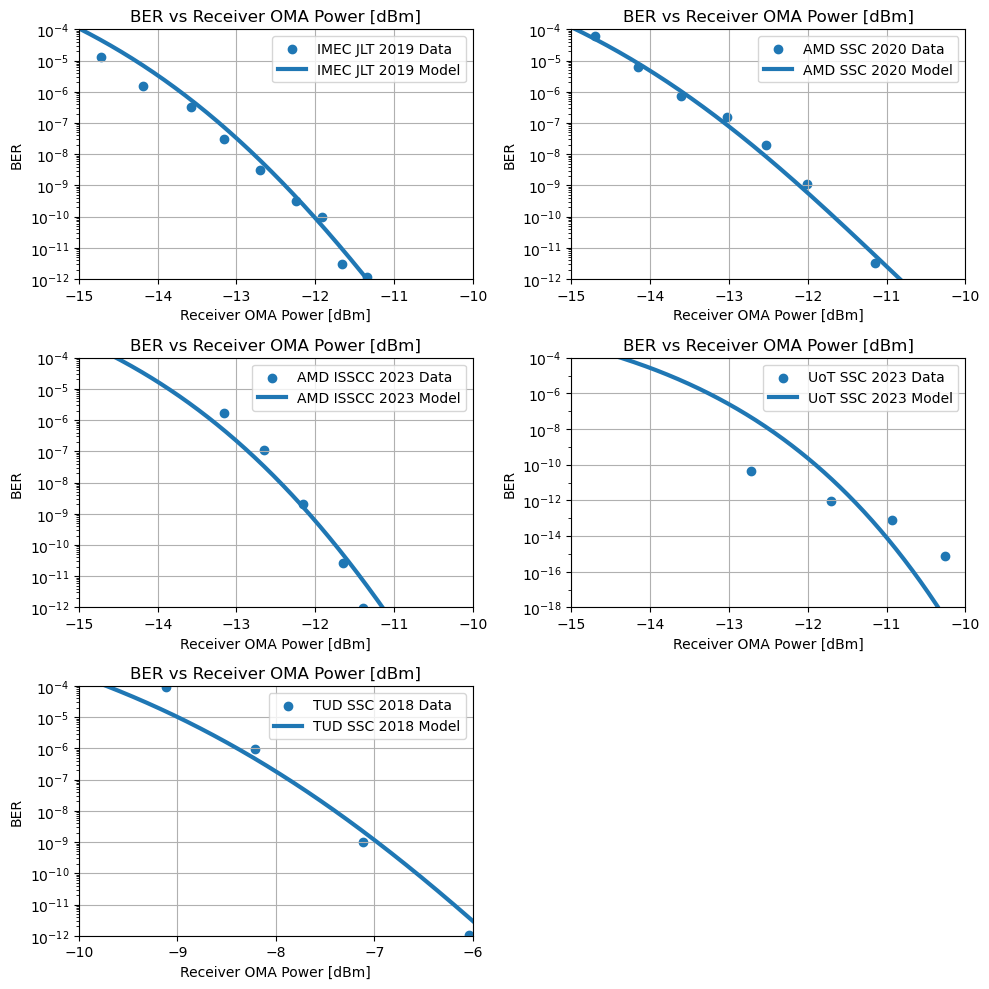

In [12]:
plt.figure(figsize = (10,10))
for idd_rx in range(5):
  plt.subplot(3, 2, idd_rx+1)
  if idd_rx == 0:
    plt.scatter(imec_jlt_2019_data['OMA'], 10**(imec_jlt_2019_data['BER']), label='IMEC JLT 2019 Data')
    plt.plot(10*np.log10(imec_jlt_2019_oma/1e-3), imec_jlt_2019_ber, linewidth=3.0, label='IMEC JLT 2019 Model')
  elif idd_rx == 1:
    plt.scatter(amd_ssc_2020_data['OMA'], 10**(amd_ssc_2020_data['BER']), label='AMD SSC 2020 Data')
    plt.plot(10*np.log10(amd_ssc_2020_oma/1e-3), amd_ssc_2020_ber, linewidth=3.0, label='AMD SSC 2020 Model')
  elif idd_rx == 2:
    plt.scatter(amd_isscc_2023_data['OMA'], 10**(amd_isscc_2023_data['BER']), label='AMD ISSCC 2023 Data')
    plt.plot(10*np.log10(amd_isscc_2023_oma/1e-3), amd_isscc_2023_ber, linewidth=3.0, label='AMD ISSCC 2023 Model')
  elif idd_rx == 3:
    plt.scatter(uoft_ssc_2023_data['OMA'], 10**(uoft_ssc_2023_data['BER']), label='UoT SSC 2023 Data')
    plt.plot(10*np.log10(uoft_ssc_2023_oma/1e-3), uoft_ssc_2023_ber, linewidth=3.0, label='UoT SSC 2023 Model')
  elif idd_rx == 4:
    plt.scatter(tud_ssc_2018_data['OMA'], 10**(tud_ssc_2018_data['BER']), label='TUD SSC 2018 Data')
    plt.plot(10*np.log10(tud_ssc_2018_oma/1e-3), tud_ssc_2018_ber, linewidth=3.0, label='TUD SSC 2018 Model')
  plt.legend()
  plt.xlabel('Receiver OMA Power [dBm]')
  plt.ylabel('BER')
  plt.yscale("logit")
  plt.grid(True)
  plt.title('BER vs Receiver OMA Power [dBm]')
  plt.xlim([-15, -10])
  plt.xticks(np.arange(-15, -9, 1.0))
  plt.ylim([1e-12, 1e-4])
  if idd_rx == 3:
    plt.ylim([1e-18, 1e-4])
  if idd_rx == 4:
    plt.xlim([-10, -6])
    plt.xticks(np.arange(-10, -5, 1.0))
    plt.ylim([1e-12, 1e-4])
  plt.yscale("logit")
plt.tight_layout()
plt.show()

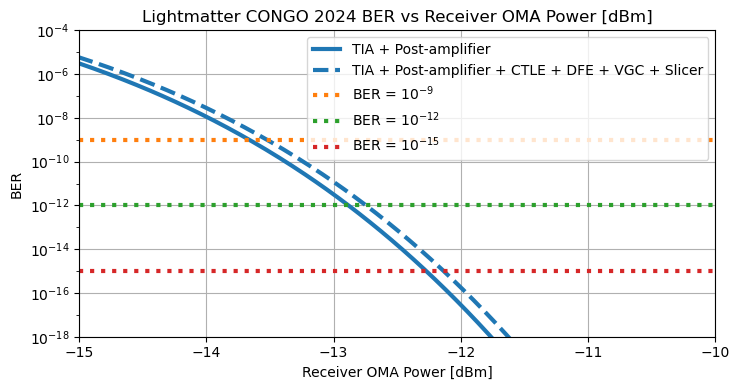

In [13]:
plt.figure(figsize = (7.5,4))
p = plt.plot(10*np.log10(lm_congo_2024_oma/1e-3), lm_congo_2024_ber, linewidth=3.0, label='TIA + Post-amplifier')
plt.plot(10*np.log10(lm_congo_2024_rx_oma/1e-3), lm_congo_2024_rx_ber, linewidth=3.0, linestyle = '--', color = p[0].get_color(), label='TIA + Post-amplifier + CTLE + DFE + VGC + Slicer')
plt.plot(np.linspace(-15,-10, 100), 1e-9*np.ones(100), linewidth=3.0, linestyle = ':', label=r'BER = 10$^{-9}$')
plt.plot(np.linspace(-15,-10, 100), 1e-12*np.ones(100), linewidth=3.0, linestyle = ':', label=r'BER = 10$^{-12}$')
plt.plot(np.linspace(-15,-10, 100), 1e-15*np.ones(100), linewidth=3.0, linestyle = ':', label=r'BER = 10$^{-15}$')
plt.xlim([-15, -10])
plt.xticks(np.arange(-15, -9, 1.0))
plt.ylim([1e-18, 1e-4])
plt.legend()
plt.xlabel('Receiver OMA Power [dBm]')
plt.ylabel('BER')
plt.yscale("logit")
plt.grid(True)
plt.title('Lightmatter CONGO 2024 BER vs Receiver OMA Power [dBm]')
plt.tight_layout()
plt.show()

In [14]:
congo_tia_postamp = optical_links['lm_congo_2024']
congo_rx = optical_links['lm_congo_2024_v2']

In [15]:
target_m9_tia_postamp_pave = np.argmax(lm_congo_2024_ber < 1e-9)
target_m9_rx_pave = np.argmax(lm_congo_2024_rx_ber < 1e-9)

target_m12_tia_postamp_pave = np.argmax(lm_congo_2024_ber < 1e-12)
target_m12_rx_pave = np.argmax(lm_congo_2024_rx_ber < 1e-12)

target_m15_tia_postamp_pave = np.argmax(lm_congo_2024_ber < 1e-15)
target_m15_rx_pave = np.argmax(lm_congo_2024_rx_ber < 1e-15)

In [16]:
print('TIA + Postamp Pave targetting BER =  1e-9')
congo_tia_postamp['link_dict'][target_m9_tia_postamp_pave]

TIA + Postamp Pave targetting BER =  1e-9


{'responsivity': 0.9,
 'bandwidth': 30000000000.0,
 'average_power': 6.495311744387621e-05,
 'extinction_ratio': 0.5011872336272722,
 'temperature': 378,
 'tia_irn': 2.33e-06,
 'relative_intensity_noise': 3.1622776601683794e-15,
 'eye_close_penalty': 0.78,
 'power_1': 8.65356645578873e-05,
 'power_0': 4.337057032986512e-05,
 'shot_noise_1': 8.652660092228681e-07,
 'shot_noise_0': 6.12561423600216e-07,
 'laser_rin_1': 7.58574553309065e-07,
 'laser_rin_0': 3.8018788187301405e-07,
 'sigma_1': 2.598657464854596e-06,
 'sigma_0': 2.438990431142815e-06,
 'oma': 4.316509422802218e-05,
 'current_oma': 3.0301896148071572e-05,
 'personick_q': 6.0150881470194655,
 'ber': 8.989442105842653e-10}

In [17]:
print('RX Pave targetting BER =  1e-9')
congo_rx['link_dict'][target_m9_rx_pave]

RX Pave targetting BER =  1e-9


{'responsivity': 0.9,
 'bandwidth': 30000000000.0,
 'average_power': 6.701931737237643e-05,
 'extinction_ratio': 0.5011872336272722,
 'temperature': 378,
 'tia_irn': 2.41e-06,
 'relative_intensity_noise': 3.1622776601683794e-15,
 'eye_close_penalty': 0.78,
 'power_1': 8.928841902077694e-05,
 'power_0': 4.475021572397591e-05,
 'shot_noise_1': 8.78920599750743e-07,
 'shot_noise_0': 6.222281334019166e-07,
 'laser_rin_1': 7.827052917476561e-07,
 'laser_rin_0': 3.922818999164349e-07,
 'sigma_1': 2.6820195738278994e-06,
 'sigma_0': 2.519752555113077e-06,
 'oma': 4.453820329680103e-05,
 'current_oma': 3.126581871435433e-05,
 'personick_q': 6.010609065399354,
 'ber': 9.241380762570528e-10}

In [18]:
print('TIA + Postamp Pave targetting BER =  1e-12')
congo_tia_postamp['link_dict'][target_m12_tia_postamp_pave]

TIA + Postamp Pave targetting BER =  1e-12


{'responsivity': 0.9,
 'bandwidth': 30000000000.0,
 'average_power': 7.776783344557058e-05,
 'extinction_ratio': 0.5011872336272722,
 'temperature': 378,
 'tia_irn': 2.33e-06,
 'relative_intensity_noise': 3.1622776601683794e-15,
 'eye_close_penalty': 0.78,
 'power_1': 0.00010360843964501693,
 'power_0': 5.1927227246124234e-05,
 'shot_noise_1': 9.467812386480865e-07,
 'shot_noise_0': 6.702697866349052e-07,
 'laser_rin_1': 9.082350753797316e-07,
 'laser_rin_0': 4.5519582491282474e-07,
 'sigma_1': 2.673983108773508e-06,
 'sigma_0': 2.4668532234191944e-06,
 'oma': 5.168121239889269e-05,
 'current_oma': 3.628021110402267e-05,
 'personick_q': 7.05725853920508,
 'ber': 8.490974662114538e-13}

In [19]:
print('RX Pave targetting BER =  1e-12')
congo_rx['link_dict'][target_m12_rx_pave]

RX Pave targetting BER =  1e-12


{'responsivity': 0.9,
 'bandwidth': 30000000000.0,
 'average_power': 8.024167763085844e-05,
 'extinction_ratio': 0.5011872336272722,
 'temperature': 378,
 'tia_irn': 2.41e-06,
 'relative_intensity_noise': 3.1622776601683794e-15,
 'eye_close_penalty': 0.78,
 'power_1': 0.00010690428992920885,
 'power_0': 5.357906533250804e-05,
 'shot_noise_1': 9.617222047734344e-07,
 'shot_noise_0': 6.808471806179714e-07,
 'laser_rin_1': 9.371266100998699e-07,
 'laser_rin_0': 4.6967589327445714e-07,
 'sigma_1': 2.7588432145577877e-06,
 'sigma_0': 2.5479890753452217e-06,
 'oma': 5.3325224596700804e-05,
 'current_oma': 3.743430766688397e-05,
 'personick_q': 7.053983548360474,
 'ber': 8.693347229770153e-13}

In [20]:
print('TIA + Postamp Pave targetting BER =  1e-15')
congo_tia_postamp['link_dict'][target_m15_tia_postamp_pave]

TIA + Postamp Pave targetting BER =  1e-15


{'responsivity': 0.9,
 'bandwidth': 30000000000.0,
 'average_power': 8.953647655495937e-05,
 'extinction_ratio': 0.5011872336272722,
 'temperature': 378,
 'tia_irn': 2.33e-06,
 'relative_intensity_noise': 3.1622776601683794e-15,
 'eye_close_penalty': 0.78,
 'power_1': 0.00011928755394304168,
 'power_0': 5.978539916687707e-05,
 'shot_noise_1': 1.015896919443406e-06,
 'shot_noise_0': 7.191999414887914e-07,
 'laser_rin_1': 1.0456787199818905e-06,
 'laser_rin_0': 5.240808249306307e-07,
 'sigma_1': 2.7485251565808103e-06,
 'sigma_0': 2.494155020622706e-06,
 'oma': 5.950215477616461e-05,
 'current_oma': 4.177051265286756e-05,
 'personick_q': 7.967396682806666,
 'ber': 8.102592020532267e-16}

In [21]:
print('RX Pave targetting BER =  1e-15')
congo_rx['link_dict'][target_m15_rx_pave]

RX Pave targetting BER =  1e-15


{'responsivity': 0.9,
 'bandwidth': 30000000000.0,
 'average_power': 9.238468875379446e-05,
 'extinction_ratio': 0.5011872336272722,
 'temperature': 378,
 'tia_irn': 2.41e-06,
 'relative_intensity_noise': 3.1622776601683794e-15,
 'eye_close_penalty': 0.78,
 'power_1': 0.00012308216681348696,
 'power_0': 6.168721069410198e-05,
 'shot_noise_1': 1.0319285863593268e-06,
 'shot_noise_0': 7.305494924985682e-07,
 'laser_rin_1': 1.0789424243503166e-06,
 'laser_rin_0': 5.407521689032377e-07,
 'sigma_1': 2.8349767833984986e-06,
 'sigma_0': 2.575697084123727e-06,
 'oma': 6.139495611938497e-05,
 'current_oma': 4.309925919580826e-05,
 'personick_q': 7.965599156606572,
 'ber': 8.221256284951731e-16}